# Tugas Besar TF4012 Pengukuran Berbasis Citra
### Model Training

**Nama**: Febricetta Zahraketzia Sarwono </br>
**NIM**: 13319080

In [1]:
# import library
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# listing dataset
A = list(('ds/A/*'))
C = list(('ds/C/*'))
I = list(('ds/I/*'))
T = list(('ds/T/*'))
R = list(('ds/R/*'))

In [3]:
# image size
batch_size = 128
img_height = 299
img_width = 299

In [4]:
# file checking
from pathlib import Path
import imghdr
image_extensions = [".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path('ds').rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [5]:
# training files
data = 'ds'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size)

Found 2500 files belonging to 5 classes.
Using 2000 files for training.


In [6]:
# validation files
val_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  shuffle=True,
  batch_size=batch_size)

Found 2500 files belonging to 5 classes.
Using 500 files for validation.


In [7]:
# classes
class_names = train_ds.class_names
print(class_names)

['A', 'C', 'I', 'R', 'T']


In [9]:
# image and label batch shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 299, 299, 3)
(128,)


In [10]:
# autotune and normalizaton
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [11]:
# ResNet50 pretrained model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_width, img_height, 3),
    pooling='avg',
    classes=5,
)

for layer in pretrained_model.layers:
  layer.trainable = False

In [12]:
# additional model layer
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

In [13]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
# compile model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# model fitting
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True,
)

Epoch 1/15


c:\Users\cetta sarwono\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


16/16 [==============================] - 607s 38s/step - loss: 1.2207 - accuracy: 0.5930 - val_loss: 0.7189 - val_accuracy: 0.8320
Epoch 2/15
16/16 [==============================] - 550s 34s/step - loss: 0.6012 - accuracy: 0.8765 - val_loss: 0.4167 - val_accuracy: 0.9840
Epoch 3/15
16/16 [==============================] - 572s 36s/step - loss: 0.3902 - accuracy: 0.9590 - val_loss: 0.2892 - val_accuracy: 0.9920
Epoch 4/15
16/16 [==============================] - 555s 35s/step - loss: 0.2886 - accuracy: 0.9760 - val_loss: 0.2171 - val_accuracy: 1.0000
Epoch 5/15
16/16 [==============================] - 594s 37s/step - loss: 0.2237 - accuracy: 0.9870 - val_loss: 0.1795 - val_accuracy: 0.9920
Epoch 6/15
16/16 [==============================] - 499s 32s/step - loss: 0.1779 - accuracy: 0.9930 - val_loss: 0.1406 - val_accuracy: 1.0000
Epoch 7/15
16/16 [==============================] - 550s 34s/step - loss: 0.1507 - accuracy: 0.9955 - val_loss: 0.1224 - val_accuracy: 1.0000
Epoch 8/15
16/16 

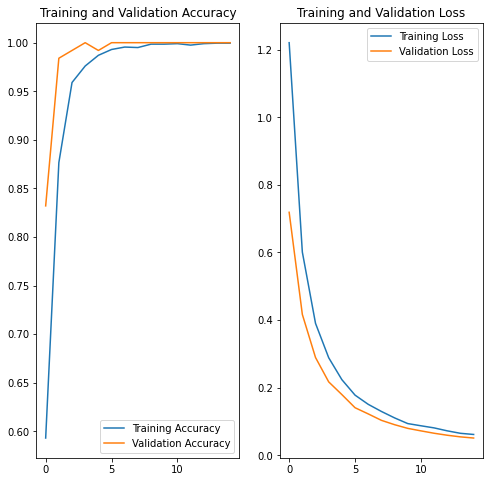

In [16]:
# accuracy and loss training and validation plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# saving model
model.save('signdecoderv2.h5')
model.save_weights('signdecoder_weightsv2.h5')

c:\Users\cetta sarwono\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
